### Registration of the brain to the atlas

Registration is done with [Elastix](https://elastix.lumc.nl/) command line interface. Elastix is a commonly used image registration software based on [ITK](https://itk.org/) - *Insight Segmentation and Registration Toolkit*.

To align the brains you need the downsampled data and the atlas. 
In our hands, registration works best if the brain and the atlas are in the same orientation. 

Registration steps:

 1. Downsample the raw data
 2. Find the best orientation on the autofluorescence imaged brain that best matches the atlas [MANUAL STEP]
 3. Align the autofluorescence brain to the atlas using ELASTIX
 4. Apply the transformations to the other brains using TRANSFORMIX
    
    

In [1]:
# Downsample the raw data
from deeptrace import *
stack = BrainStack(channel_folders=['/home/joao/deeptrace_data/210723_NAc326F_488_s3_0_8x_13-31-25/',
                   '/home/joao/deeptrace_data/210723_NAc326F_640_s3_0_8x_11-50-51/'])
stack.downsample(channel_indices=[0,1])

['/home/joao/deeptrace_data/deeptrace_analysis/210723_NAc326F_488_s3_0_8x_13-31-25/scaled/210723_NAc326F_488_s3_0_8x_13-31-25.tif',
 '/home/joao/deeptrace_data/deeptrace_analysis/210723_NAc326F_488_s3_0_8x_13-31-25/scaled/210723_NAc326F_640_s3_0_8x_11-50-51.tif']

In [2]:
%matplotlib qt
from deeptrace.plotting import *

dstack = stack.downsampled_stack[0]
res = interact_find_angles(dstack)


The cell above will open an interactive window and create a dictionary called `res`. That dictionary contains points selected in the interactive window and the angle estimate based on the selected points.

To **navigate the stack** use the arrow keys or drag the slider.
You need to select 2 sets of 3d points that should be in the same plane. 

We tipically use blood vessels close to the midline for this. Find a vessel and press the **z** key, then move the plane and find the same vessel in the other plane. Hover the mouse over it and press **shift+z**.

To **close** the window press **q**


**Note**: We are currently only estimating Z plane rotations.

In [7]:
print('The estimated angles from the iteractive window are: {0}'.format(res['angles']))
rstack = rotate_stack(dstack,*res['angles'])

interact_show_stack(rstack)  # this to see the results


The estimated angles from the iteractive window are: [3.6247535, 0, 0]


Now we can run Elastix on the rotated stack and to match to the atlas.

Check the inputs to the `elastix_fit` function to pass a different atlas than the one in the preference file.

In [ ]:
# find the elastix transform
rstack = imread('/home/joao/deeptrace_data/deeptrace_analysis/210723_NAc326F_488_s3_0_8x_13-31-25/rotated/align_channel.tiff')
fitstack,transformpath = elastix_fit(rstack,outpath='/home/joao/deeptrace_data')

Now that the transforms are computed from the autofluorescence stack, you can apply those transforms to the segmented data or data from other channels.

In [7]:
rotated_segmentation = imread('/home/joao/deeptrace_data/deeptrace_analysis/210723_NAc326F_488_s3_0_8x_13-31-25/rotated/denardo_model1_seg_210723_NAc326F_640_s3_0_8x_11-50-51.tiff')
# alternatively you can run rotate the segmentation using the same paratemers
# rstack = rotate_stack(sementation_stack,*res['angles'])

transformed_segmentation = elastix_apply_transform(rotated_segmentation,'/home/joao/deeptrace_data')


Look at the overlay of the 2 channels (segmented and autofluorescence)

In [10]:
interact_show_stack(np.stack([transformed_segmentation, # red
                              4*fitstack, # green
                              fitstack*0  # blue
                             ]).transpose([1,2,3,0]).astype('uint8'))

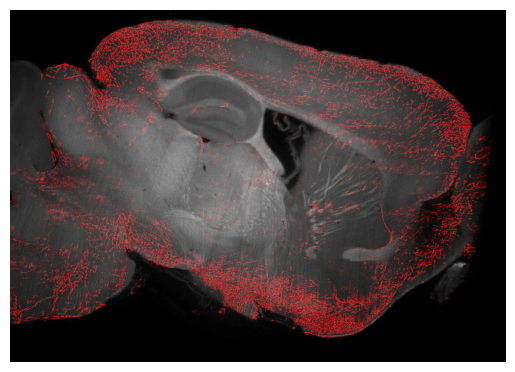

In [27]:
# plot a single plane
iplane = 440
R = transformed_segmentation[iplane]
G = fitstack[iplane]*5
%matplotlib inline
plt.figure()
plt.imshow(np.stack([R+G,G,G]).transpose([2,1,0]).astype('uint8'))
plt.axis('off');